# COVID politics 2021

### Main ideas

Did people react differently to COVID-19 depending on their political beliefs?
(Does it generate more controversy than other topics controversy?)

This notebook intends to visualize if such relationship exists, and if so, quantify it.

The study is focused in the US due to two main factors:
 - Data availability
 - "Simplified" political landscape
 
### Introduction 
 
It is impossible to separate now 2020 to the pandemic. Despite the certain feeling that COVID-19 paralyzed the world, the pandemic itself has been far from still. The relentless spread of the virus has taken many forms inside ourselves: what is going on in Wuhan? What is going in Italy? How long will the lockdown last? Are masks effective? Which company is making the vaccine? The urgency and total presence of such topics have modified our discussions and the way we discuss them. Speaking of discussing, could the mental takeover be different depending on your political views?

In order to check this, first we will investigate the headlines in the subreddit r/Coronavirus, to discern the main relevant topics that have flooded our conversations during 2020. Then, identifying the clusters of words that are representative from that topic in particular, we can look them up un forums intended to political discussion. In this case, we take advantage of the community based structure of reddit to compare the evolution and impact of those topic in r/republican and r/democrats.


## Data sources

https://reddit-api.readthedocs.io/en/latest/
https://electionlab.mit.edu/data
https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX

https://reddit-api.readthedocs.io/en/latest/#comments-search

In [228]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime as dt
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import multiprocessing
from itertools import product

#Import visualization tools for LDA models
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
import string

from sklearn.feature_extraction.text import TfidfVectorizer
#Import LDA topic modelling plugin from sklearn
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.sklearn

# Importing local functions
from COVID_functions import *

pd.options.mode.chained_assignment = None

from colour import Color

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/COVID_functions.py:31: DeprecationWarning: invalid escape sequence \y
  awkward_sep = '_/zvzvzvzv/EndOfElement\yxyxyxy\_'


In [92]:
data_folder = '/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/data/posts/submissions/coronavirus/'

metadf1_column_titles = ['created_utc',
          'author',
          'subreddit',
          'score',
          'id',
          'title',
          'num_comments',
          'num_crossposts',
          'subreddit_subscribers',
          'author_flair_text',
          'author_flair_type']

#time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(praw_submission.created_utc))

# creating empty elements
metadat0 = pd.DataFrame(columns = metadf1_column_titles)
meta_file_path = data_folder + 'metadata1.txt'

metadat0 = pd.read_csv(meta_file_path, sep='\t', header = None, names = metadf1_column_titles)
metadat0['TimeStamp'] = pd.to_datetime(metadat0['created_utc'], unit = 's')
metadat0['date'] = metadat0['TimeStamp'].dt.date
metadat0['period'] = metadat0['TimeStamp'].astype('int')//(1e9*60*60*24*1)
metadat0['period'] = metadat0['TimeStamp'].dt.dayofyear

dc19 = metadat0[metadat0['TimeStamp'].dt.year.isin([2020])]
dc19['hour'] = dc19['TimeStamp'].dt.hour

dc19.head(20)

,created_utc,author,subreddit,score,id,title,num_comments,num_crossposts,subreddit_subscribers,author_flair_text,author_flair_type,TimeStamp,date,period,hour
0,1579552351,robbye91,Coronavirus,1,erj61t,When should we start to get worried about the ...,94,0,6,None,text,2020-01-20 20:32:31,2020-01-20,20,20
1,1579671329,mcmartian2240,Coronavirus,1,es7jnl,#plague2020,1,0,54,None,text,2020-01-22 05:35:29,2020-01-22,22,5
2,1579674580,TheLordOfCereals,Coronavirus,1,es83ce,Trump will fight against corona virus,6,0,56,None,text,2020-01-22 06:29:40,2020-01-22,22,6
3,1579760266,blackie6644,Coronavirus,1,esp4td,"how people in Wuhan eat roast bats, bat sushi,...",8,0,162,None,text,2020-01-23 06:17:46,2020-01-23,23,6
4,1579742601,blocketjoe,Coronavirus,1,eslqng,China Is On Lockdown Due To Corona Virus!,3,0,130,None,text,2020-01-23 01:23:21,2020-01-23,23,1
5,1579773673,Silver_Linings_89,Coronavirus,1,esqzz1,Modeling the spread of diseases like the Coron...,0,0,206,None,text,2020-01-23 10:01:13,2020-01-23,23,10
6,1579774394,SealDrop,Coronavirus,1,esr4as,CORONA VIRUS MEMES,1,0,209,None,text,2020-01-23 10:13:14,2020-01-23,23,10
7,1579740470,bipboop11,Coronavirus,1,esla8o,Disease control questions,10,0,125,None,text,2020-01-23 00:47:50,2020-01-23,23,0
8,1579771680,ssbani,Coronavirus,1,esqq1m,Scientist says Snakes could be the source of C...,0,0,199,None,text,2020-01-23 09:28:00,2020-01-23,23,9
9,1579740306,N1ma1,Coronavirus,1,esl8yk,I predicted what happened a week or so beforeh...,4,0,125,None,text,2020-01-23 00:45:06,2020-01-23,23,0


In [93]:
stop_words = stopwords.words('english')

stopwords_alt = []
with open('/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/stopword_list.txt', 'r') as file:
    stopwords_alt = file.read().split('\n')
    
stopwords_alt = stopwords_alt + ['time', 'state', '10','–',
                                 '1','2','3','2020','amid','de','en','day',
                                 'people','case','cases','florida','live','update','updating',
                                 'covid19', 'coronavirus','covid','virus']

def tokenizer(text):
    '''
    -covert everything to lowercase
    -remove punctuations
    -remove stopwords
    -stemmer
    '''
    #All characters in this string will be converted to lowercase
    text = text.lower()
    
    #Removing sentence punctuations
    for punctuation_mark in string.punctuation:
        text = text.replace(punctuation_mark,'')
    
    #Creating our list of tokens
    list_of_tokens = text.split(' ')
    #Creating our cleaned tokens list 
    cleaned_tokens = []
    #Let us use a stemmer
    stemmer = SnowballStemmer(language = 'english')
    
    #Removing Stop Words in our list of tokens and any tokens that happens to be empty strings
    for token in list_of_tokens:
        if (not token in stopwords_alt) and (token != ''):
            #Stem tokens
            token_stemmed = stemmer.stem(token)
            #appending our finalized cleaned token
            cleaned_tokens.append(token_stemmed)
    
    return cleaned_tokens

In [94]:
#Instatiate TFIDF Vectorizer
tfidf = TfidfVectorizer(tokenizer = tokenizer,
                            # min_df = 365,
                          min_df = 0.015, 
                           analyzer='word',
                           ngram_range = (1,1))

#dc19.comments is referring to the text column from my dataframe containing the comments
token_matrix = tfidf.fit_transform(dc19.title)

#If you would like to store the matrix to a dataframe, execute the code below
matrix_df = pd.DataFrame(token_matrix.toarray(), columns = tfidf.get_feature_names())

#I'm looking for the top n words for each topic
token_names = tfidf.get_feature_names()

In [95]:
controversy_topics = ['china', 'lockdown', 'mask', 'outbreak', 'quarantin', 'vaccin']

from collections import Counter
from wordcloud import WordCloud, get_single_color_func
from os import path
import os

class colormap_color_func(object):
    """Color func created from matplotlib colormap.

    Parameters
    ----------
    colormap : string or matplotlib colormap
        Colormap to sample from

    Example
    -------
    >>> WordCloud(color_func=colormap_color_func("magma"))

    """
    def __init__(self, colormap):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = np.maximum(0, 255 * np.array(self.colormap(
            random_state.uniform(0, 1))))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)
    

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

image_folder = '/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/'

for mci in controversy_topics:
    
    word_could_dict=Counter([mci])

    # The Symbola font includes most emoji
    font_path = path.join(d, 'fonts', 'GothamBold.ttf')
    wordcloud = WordCloud(width = 840, height = 240, background_color='white',
                          font_path = font_path, color_func=colormap_color_func("magma"),
                          min_font_size =60, max_font_size = 150).generate_from_frequencies(word_could_dict)
    
    plt.figure(figsize=(12,4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(path.join(d,'images',''.join(['wc_',mci,'.png'])), bbox_inches='tight')
    plt.close()

In [96]:
def ReturnCoocMat(t_m, wl):
    
    # Returns a N-square matrix where N is the number of words of a topic.
    # The matrix diagonal is always 1
    # The matrix is symetric
    
    # When the word i is said, how many times j is said.

    from collections import Counter
    
    nwl = len(wl)
    mat = np.zeros((nwl,nwl))
    
    tokens_tm = tokenizer(t_m)
    c = Counter(x for x in tokens_tm if x)
    # selecting only the topic words
    c_topic = Counter({k: 0  for k in wl})
    
    c_topic.update(c)
    
    for i,w in enumerate(wl):
        if c_topic[w] != 0:
            mat[i,i] = 1
            for j in range(i+1, nwl):
                mat[i,j] = mat[j,i] = c_topic[wl[j]]/c_topic[w]
    
    return mat

In [97]:
# Generating a mean of matrices
words_in_matrix = token_names

Nwt = len(words_in_matrix)
Mat = np.zeros((Nwt,Nwt))

for title in dc19.title:
    Mat = Mat + ReturnCoocMat(title, words_in_matrix)
    
Mat = Mat/dc19.shape[0]

/home/jpre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


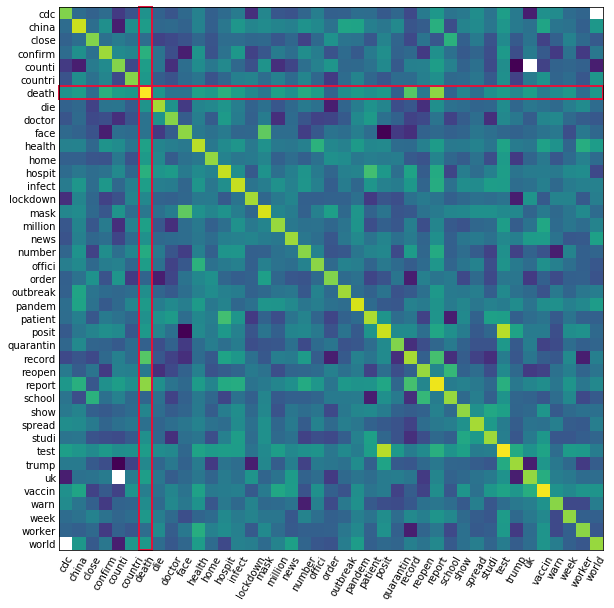

In [147]:
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

labels = words_in_matrix
N = len(labels)

#####

Matlog = np.log(Mat)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(Matlog)

ax.set_yticks(range(len(words_in_matrix)))
ax.set_yticklabels(words_in_matrix)
ax.set_xticks(range(len(words_in_matrix)))
ax.set_xticklabels(words_in_matrix, rotation = 60)

wanted_label = 'death'
wanted_index = labels.index(wanted_label)
x, y, w, h = -0.5, wanted_index-0.5, N, 1
for _ in range(2):
    ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='crimson', lw=2, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h
ax.tick_params(length=0)

# Hide grid lines
ax.grid(False)

plt.show()

In [99]:
from bokeh.layouts import gridplot, layout, Spacer, row
from bokeh.models.annotations import Title
from bokeh.models import ColumnDataSource, Legend, Rect, LegendItem, Span, Arrow, NormalHead, OpenHead, VeeHead
from bokeh.models import BoxAnnotation, Label, InvertedTriangle, Text, Triangle, Line, ImageURL, Image
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_file, show, output_notebook, save, show
from bokeh.io import show
from bokeh.embed import components
from bokeh.core.properties import value

from bokeh.palettes import Category20
from bokeh.io import output_file, reset_output

from copy import deepcopy

In [100]:
def CountWord(title, word):
    
    from collections import Counter 
    
    tokens = tokenizer(title)
    
    c = Counter(tokens)
    
    if word in c.keys():
        return c[word]
    else:
        return 0

for w_i in controversy_topics:
    dc19[w_i] = dc19.title.apply(lambda x: CountWord(x, w_i))
    
datest = dc19[['period'] + controversy_topics].groupby('period').agg(np.mean)

,china,lockdown,mask,outbreak,quarantin,vaccin
period,,,,,,
20,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,0.162162,0.027027,0.000000,0.027027,0.000000,0.000000
24,0.136364,0.000000,0.009091,0.072727,0.009091,0.000000
25,0.096939,0.010204,0.015306,0.030612,0.000000,0.005102


In [142]:
from localreg import *

x = np.linspace(1.5, 5, 2000)
yf = np.sin(x*x)
y = yf + 0.5*np.random.randn(*x.shape)

for w in controversy_topics:
    name_sm = '_'.join([w,'ks'])
    x = datest.index.to_numpy()
    y = datest[w].to_numpy()
    datest[name_sm] = localreg(x, y, x0 = x, kernel=rbf.epanechnikov, width=14, frac=None)
    
datest.head()

,china,lockdown,mask,outbreak,quarantin,vaccin,zero,china_ks,lockdown_ks,mask_ks,outbreak_ks,quarantin_ks,vaccin_ks
period,,,,,,,,,,,,,
20,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0,0.008642,0.003898,-0.010069,0.718844,-0.006215,-0.002935
22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.059557,0.005813,0.002906,0.348142,0.002761,0.000664
23,0.162162,0.027027,0.000000,0.027027,0.000000,0.000000,0,0.077336,0.005536,0.011340,0.236996,0.007777,0.002090
24,0.136364,0.000000,0.009091,0.072727,0.009091,0.000000,0,0.091937,0.004825,0.019140,0.157476,0.011611,0.003075
25,0.096939,0.010204,0.015306,0.030612,0.000000,0.005102,0,0.103401,0.004181,0.026708,0.100932,0.015007,0.003760


In [143]:

# Settting the figure object
output_notebook()

items = [] # items for legend
lines ={} # bar-information for plotting
days = list(range(106))

rngsize = 10
TOOLS = "hover,save,reset"

List_of_plots = []
topics_to_plot = prob_topics

datest['zero'] = 0

for indx,i in enumerate(controversy_topics):
    
    smooth_i = '_'.join([i,'ks'])
    
    max_freq = 1.05*max(datest[i])
    
    p = figure(plot_width= 320, plot_height=120, title = None, x_range=(2,366) ,y_range = (0,max_freq), tools = '')

    source = ColumnDataSource(data=datest.reset_index())
    
    image_bkg = path.join('.','images',''.join(['wc_',i,'.png']))
    r_image = p.image_url(url=[image_bkg], x=4, y=0, w=366-4, h=max_freq, global_alpha = 0.9, anchor = 'bottom_left')
    r_rect = p.rect(x=-10, y = -10, height = 100, width = 1000, fill_color = 'skyblue', fill_alpha = 0.99)
    r = p.scatter(y=i, x='period', color='red', source=source, alpha = 1)
    p.line(y=smooth_i, x='period', color='pink', source=source, alpha = 1, line_width = 2.5)
    glyph = Text(x='x', y='y', text="text", angle=0., text_color="pink", text_alpha = 0.1)
    r_text = p.add_glyph(ColumnDataSource(dict(x=[25], y=[0.1], text=[i])), glyph)
    
    hover1 = HoverTool(tooltips=[('day',  '@period')],renderers = [r], mode = 'vline')
    hover2 = HoverTool(tooltips = None, renderers = [r_text])
    hover3 = HoverTool(tooltips = [("x", "$x"),("y", "$y")], renderers = [r_rect])
    
    p.tools.append(hover1)
    p.tools.append(hover2)
    p.tools.append(hover3)

    selected_line = Line(line_alpha=0.8, line_color='pink', line_width = 2.5)
    selected_rect = Rect(fill_alpha=0.1, fill_color = 'white')
    selected_text = Text(text_alpha=1, text_font_style = 'bold')

    # I add the selection glyph because I want to fix a particular line for comparing
    r.hover_glyph = selected_line
    r_text.hover_glyph = selected_text
    r_rect.hover_glyph = selected_rect
    
    # Adjusting plot parameters
    #p.x_range.range_padding = 0.05
    p.xaxis.axis_label = ""
    p.yaxis.axis_label = ""
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.yaxis.axis_line_width = 1
    p.yaxis.ticker = [0,max_freq]
    p.grid.visible = False
    p.background_fill_color = 'white'
    p.background_fill_alpha = 1
        
    List_of_plots.append(p)
    
    
p_all = gridplot(List_of_plots, ncols=3)

show(p_all)

Loading BokehJS ...

# Comparing political response

In [ ]:
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default

In [250]:
agg_step = 'month'
rel_columns = ['period', 'comments','TimeStamp'] + controversy_topics

In [248]:
df0 = ReadSubreddit('republican', agg_step = agg_step)

comments_ = df0.comments.tolist()

all_comments = ' '.join(comments_)

n_comments = len(comments_)
num_topics = len(controversy_topics)

pool = multiprocessing.Pool(processes=cpus)
matrix_list = pool.starmap(CountWord, product(comments_,controversy_topics))

matrix_probs = np.array(matrix_list)
shape = (n_comments, num_topics)
matrix_df = pd.DataFrame(matrix_probs.reshape(shape))
matrix_df.columns = controversy_topics

df0 = pd.concat([df0.reset_index(), matrix_df.reset_index()], axis=1)

In [251]:
topww = df0[rel_columns].groupby(['period']).agg(date = ('TimeStamp',min),
                                                 mask=('mask',np.mean),
                                                 china=('china',np.mean),
                                                 lockdown=('lockdown',np.mean),
                                                 vaccin=('vaccin',np.mean),
                                                 outbreak=('outbreak',np.mean),
                                                 quarantin=('quarantin',np.mean)).reset_index()

In [252]:
df1 = ReadSubreddit('democrats', agg_step = agg_step)

comments_ = df1.comments.tolist()

all_comments = ' '.join(comments_)

n_comments = len(comments_)
num_topics = len(controversy_topics)

pool = multiprocessing.Pool(processes=cpus)
matrix_list = pool.starmap(CountWord, product(comments_,controversy_topics))

matrix_probs = np.array(matrix_list)
shape = (n_comments, num_topics)
matrix_df = pd.DataFrame(matrix_probs.reshape(shape))
matrix_df.columns = controversy_topics

df1 = pd.concat([df1.reset_index(), matrix_df.reset_index()], axis=1)

In [253]:
topww1 = df1[rel_columns].groupby(['period']).agg(date = ('TimeStamp',min),
                                                  mask=('mask',np.mean),
                                                  china=('china',np.mean),
                                                  lockdown=('lockdown',np.mean),
                                                  vaccin=('vaccin',np.mean),
                                                  outbreak=('outbreak',np.mean),
                                                  quarantin=('quarantin',np.mean)).reset_index()

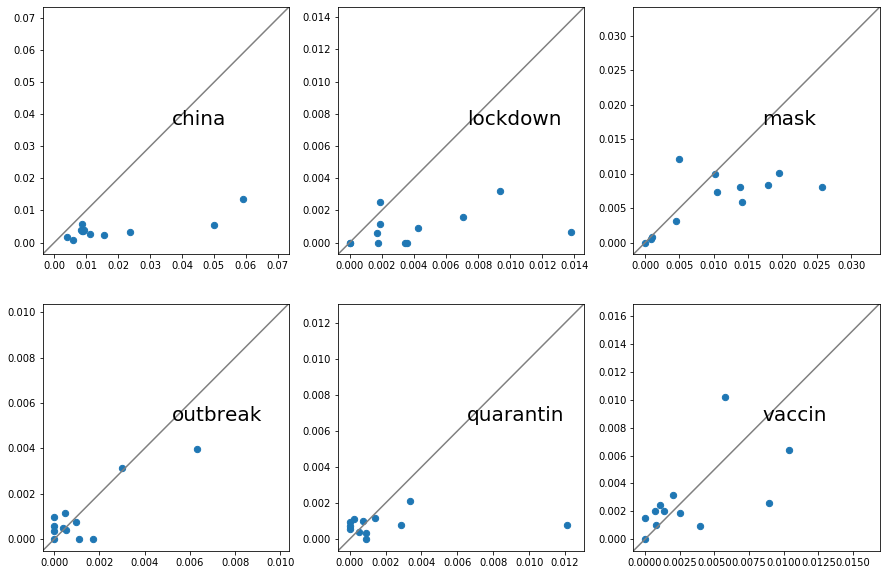

In [262]:
nrows=2
ncols=3

fig, ax = plt.subplots(nrows,ncols,figsize=(15,10))

Nobs = min(topww.shape[0], topww.shape[0])

y_rep = topww['mask'][:Nobs]
y_dem = topww1['mask'][:Nobs]

WORDS = controversy_topics
ij = 0
for i in range(nrows):
    for j in range(ncols):
        
        w_ij = WORDS[ij]
        y_rep = topww[w_ij][:Nobs]
        y_dem = topww1[w_ij][:Nobs]
        
        xy_upperlim = 1.01*max(y_rep + y_dem)
        xy_lowerlim = -0.05*xy_upperlim
        
        ax[i,j].text(xy_upperlim/2, xy_upperlim/2, w_ij, fontsize = 20)
        ax[i,j].plot([-100,100],[-100,100], c = 'grey')
        
        ax[i,j].scatter(x=y_rep, y=y_dem, s= 40)
        ax[i,j].set_xlim(xy_lowerlim,xy_upperlim)
        ax[i,j].set_ylim(xy_lowerlim,xy_upperlim)
        
        ax[i,j].grid(False)       
        
        ij += 1
        

plt.show()

In [264]:
df1.shape, df0.shape

((22415, 33), (33762, 33))